In [1]:
import pickle
import numpy as np
import xarray as xa
import cartopy
from cartopy import crs as ccrs
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import scipy.stats
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

/global/homes/d/duan0000/.conda/envs/duan/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def start_end_time(sub_id):
    start = []
    end = []
    ext_times = ext_days[sub_id]
    length = len(ext_times)
    i = 0
    while i <= length - 1:
        j = 1
        while (j + i <= length - 1) and ((ext_times[i + j] - ext_times[i + j - 1]) / np.timedelta64(1, "D") == 1):
            j += 1
        start.append(ext_times[i] - np.timedelta64(12, "h"))
        end.append(ext_times[i + j - 1] + np.timedelta64(12, "h"))
        i += j
    return start, end

In [3]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)
data = xa.open_dataarray('cpc-global/NAM_sub_precip', engine='netcdf4')
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))
ext_days = {}
for sub_id in range(1, 8):
    print("sub_id: ", sub_id)
    precip = monsoon_precip.sel(sub_id=sub_id)
    precip_data = precip.data
    q1 = np.quantile(precip_data[precip_data > 1], 0.05)
    q2 = np.quantile(precip_data[precip_data > 1], 0.95)
    ext_time = precip.where(precip > q2, drop=True).time.data
    print(len(ext_time), q2)
    ext_days[sub_id] = ext_time


sub_id:  1
39 21.363590636973544
sub_id:  2
38 7.98353434112839
sub_id:  3
37 7.6309751208430425
sub_id:  4
77 6.2968948209451305
sub_id:  5
118 6.469523059079158
sub_id:  6
124 10.647874758983226
sub_id:  7
153 17.252742222601025


# Number of Event days
* number of epe days, instead of number of epes. (consecutive days are counted multiple times)

In [4]:
def mk_score(x, n):
    s = 0
    demo = np.ones(n)
    for k in range(n-1):
        s = s+np.sum(demo[k+1:n][x[k+1:n] > x[k]])-np.sum(demo[k+1:n][x[k+1:n] < x[k]])
    return s

def variance_s(x, n):
    unique_x = np.unique(x)
    g = len(unique_x)
    if n==g:
        var_s = (n*(n-1)*(2*n+5))/18
    else:
        tp = np.zeros(unique_x.shape)
        demo = np.ones(n)
        for i in range(g):
            tp[i] = np.sum(demo[x==unique_x[i]])
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18
    return var_s

def z_score(s, var_s):
    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    return z

def p_value(z, alpha):
    # two tail test
    p = 2*(1-norm.cdf(abs(z)))  
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z < 0) and h:
        trend = 'decreasing'
    elif (z > 0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
    
    return p, h, trend

In [5]:
def sens_slope(x):
    """
    This method proposed by Theil (1950) and Sen (1968) to estimate the magnitude of the monotonic trend. Intercept calculated using Conover, W.J. (1980) method.
    Input:
        x:   a one dimensional vector (list, numpy array or pandas series) data
    Output:
        slope: Theil-Sen estimator/slope
        intercept: intercept of Kendall-Theil Robust Line
    Examples
    --------
      >>> import numpy as np
	  >>> import pymannkendall as mk
      >>> x = np.random.rand(120)
      >>> slope,intercept = mk.sens_slope(x)
    """
    # res = namedtuple('Sens_Slope_Test', ['slope','intercept'])
    
#     x, n = __missing_values_analysis(x, method = 'skip')
    n = len(x)
    slope = np.nanmedian(sens_estimator(x))
    intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
    
    return slope, intercept
def sens_estimator(x):
    idx = 0
    n = len(x)
    print(n)
    d = np.ones(int(n*(n-1)/2))

    for i in range(n-1):
        j = np.arange(i+1,n) # all the combination of two points selected from original series. 
        d[idx : idx + len(j)] = (x[j] - x[i]) / (j - i)
        idx = idx + len(j)
        # print(i, idx)
    return d

# Sub1

40
4593.61250524041
40
0.5369017953048782 False no trend
0.6000506909101648 93.53823762690985


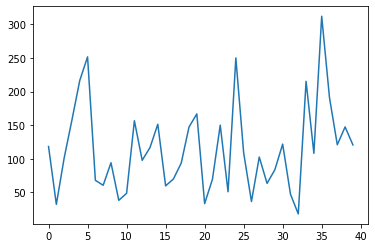

In [6]:
sub_id = 1
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    year_precip = year_precip[year_precip>1]
    total_precip = year_precip.sum()
    # print(len(ext_time), q2)
    n_epe.append(total_precip.data)
    
n = len(n_epe)
print(n)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)
plt.plot(n_epe)

In [7]:
import statsmodels.api as sm
from scipy import stats

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5974
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.444
Time:                        15:46:54   Log-Likelihood:                -224.55
No. Observations:                  40   AIC:                             453.1
Df Residuals:                      38   BIC:                             456.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.7867     21.129      4.770      0.0

In [8]:
model = LinearRegression().fit(np.arange(n).reshape(-1, 1), n_epe)
print(model.coef_)


[0.72069731]


# Sub2

In [9]:
sub_id = 2
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    year_precip = year_precip[year_precip>1]
    total_precip = year_precip.sum()
    # print(len(ext_time), q2)
    n_epe.append(total_precip.data)
print(np.sum(n_epe))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

2272.0989094232436
40
0.8248046168337546 False no trend
-0.12251368985787539 50.329824135776526


In [10]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.013
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.321
Time:                        15:46:54   Log-Likelihood:                -194.33
No. Observations:                  40   AIC:                             392.7
Df Residuals:                      38   BIC:                             396.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.3966      9.925      6.589      0.0

# Sub3

In [11]:
sub_id = 3
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    year_precip = year_precip[year_precip>1]
    total_precip = year_precip.sum()
    # print(len(ext_time), q2)
    n_epe.append(total_precip.data)
print(np.sum(n_epe), ' ', len(ext_days[sub_id]))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

2131.012547078346   37
40
0.33352610308834585 False no trend
-0.28104336005880537 47.46489045479774


In [12]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8785
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.355
Time:                        15:46:55   Log-Likelihood:                -191.19
No. Observations:                  40   AIC:                             386.4
Df Residuals:                      38   BIC:                             389.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.6755      9.175      6.613      0.0

# Sub4

In [13]:
sub_id = 4
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    year_precip = year_precip[year_precip>1]
    total_precip = year_precip.sum()
    # print(len(ext_time), q2)
    n_epe.append(total_precip.data)
print(np.sum(n_epe), ' ', len(ext_days[sub_id]))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

4129.093102444584   77
40
0.8067106222830902 False no trend
-0.09392418216157161 102.45366076193893


In [14]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                   0.02606
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.873
Time:                        15:46:55   Log-Likelihood:                -194.15
No. Observations:                  40   AIC:                             392.3
Df Residuals:                      38   BIC:                             395.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.8548      9.881     10.308      0.0

# Sub5

In [15]:
sub_id = 5
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    year_precip = year_precip[year_precip>1]
    total_precip = year_precip.sum()
    # print(len(ext_time), q2)
    n_epe.append(total_precip.data)
print(np.sum(n_epe), ' ', len(ext_days[sub_id]))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

6747.659112155144   118
40
0.7887194899032053 False no trend
0.15573527436594942 157.04395857235403


In [16]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.1029
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.750
Time:                        15:46:55   Log-Likelihood:                -204.72
No. Observations:                  40   AIC:                             413.4
Df Residuals:                      38   BIC:                             416.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        165.1388     12.867     12.834      0.0

# Sub6

In [17]:
sub_id = 6
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    year_precip = year_precip[year_precip>1]
    total_precip = year_precip.sum()
    # print(len(ext_time), q2)
    n_epe.append(total_precip.data)
print(np.sum(n_epe), ' ', len(ext_days[sub_id]))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

10107.429640396474   124
40
0.06395197805243646 False no trend
1.7033664485416855 215.42671109966136


In [18]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.019
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.319
Time:                        15:46:55   Log-Likelihood:                -226.17
No. Observations:                  40   AIC:                             456.3
Df Residuals:                      38   BIC:                             459.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        233.5764     21.998     10.618      0.0

In [19]:
model = LinearRegression().fit(np.arange(n).reshape(-1, 1), n_epe)
print(model.coef_)

[0.97996876]


## category

In [20]:
sub_id = 6
surge_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
# tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
# tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
MCS_induced_flag = np.load("ERA5/PAU/MCS_" + str(sub_id) + ".npy")
MCS_induced_flag[MCS_induced_flag < 0] = 0
midtro_flag = np.load("ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
front_flag = np.load("ERA5/PAU/" + str(sub_id) + "_front.npy")
start, end = start_end_time(sub_id)
all_time = ext_days[sub_id]

In [21]:
# TC
n_epe = find_categories_events(tc_induced_flag, end, start)
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(n)
print(np.sum(n_epe), ' Sum n_epe')
print(np.sum(tc_induced_flag), ' Sum Category')
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

NameError: name 'find_categories_events' is not defined

# Sub7

In [22]:
sub_id = 7
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    total_precip = year_precip.sum()
    # print(len(ext_time), q2)
    n_epe.append(total_precip.data)
print(np.sum(n_epe), ' ', len(ext_days[sub_id]))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

20041.438409143604   153
40
0.5680669608513922 False no trend
-1.0839621797581709 525.462273121139


In [23]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7336
Date:                Fri, 02 Jun 2023   Prob (F-statistic):              0.397
Time:                        15:47:26   Log-Likelihood:                -242.85
No. Observations:                  40   AIC:                             489.7
Df Residuals:                      38   BIC:                             493.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        525.6423     33.386     15.745      0.0